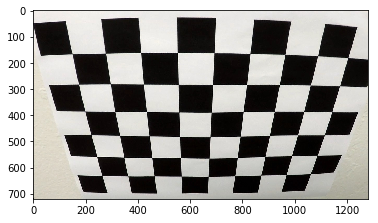

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

nx = 9 #inside corners in x
ny = 6 # inside corners in y
img  = mpimg.imread('camera_cal/calibration2.jpg')
plt.imshow(img)

In [3]:
def calibrate_camera(images):
    
    

    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane

# preparing objpoints
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for fname in images:
        
        img = cv2.imread(fname)
    
        #Converting img into grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        #finding chessboard Corners
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img.shape[1::-1],None,None)
    return ret,mtx,dist,rvecs,tvecs

In [4]:
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

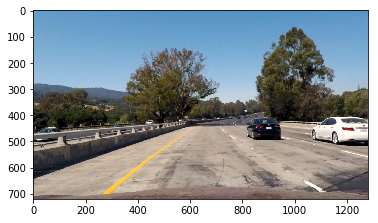

In [5]:
def cal_undistort(img):
    
    
    undist = cv2.undistort(img,mtx,dist,None,mtx) 
    
    return undist
im = mpimg.imread("test_images/test1.jpg")
undistorted = cal_undistort(im)
plt.imshow(undistorted)
plt.savefig('output_images/Undistorted Image')

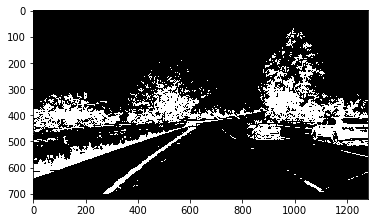

In [76]:
im = mpimg.imread("test_images/test1.jpg")


def pipeline(img,r_thresh =(215,255), s_thresh=(180, 255), sx_thresh=(120, 255),l_thresh = (10,50)):
    img = np.copy(img)
    img = cal_undistort(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel>=l_thresh[0])&(l_channel<l_thresh[1])] = 1
    
    #threshold R Channel
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel>=r_thresh[0])&(r_channel<=r_thresh[1])] = 1
    # Stack each channel
    combined = np.zeros_like(sxbinary)
    combined[(sxbinary==1)|(s_binary ==1)|(l_binary==1)|(r_binary==1)]=1
    return combined
    
result = pipeline(im) 

plt.imshow(result,cmap='gray')
plt.savefig("output_images/Thresholded Image")

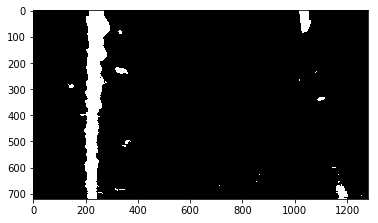

In [77]:
def perpective_transform(img):
    img = cal_undistort(img)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1200, 720],[200, 720]])
    dst = np.float32([[0, 0], [1200, 0], 
                     [1200, 720],[200, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped,M,Minv

warped,M,Minv = perpective_transform(im)
pt_1 = pipeline(warped)
plt.imshow(pt_1,cmap='gray')
plt.savefig('output_images/Perpective Tranformed and thersholded Image')

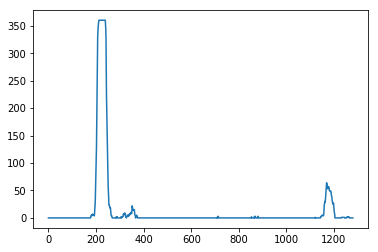

In [78]:
def hist(img):

    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[(img.shape[0]//2):,:]

    histogram = np.sum(bottom_half,axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(pt_1)

# Visualize the resulting histogram
plt.plot(histogram)
plt.savefig('output_images/Histogram')

In [79]:
def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return left_fit,right_fit,left_fitx,right_fitx,out_img


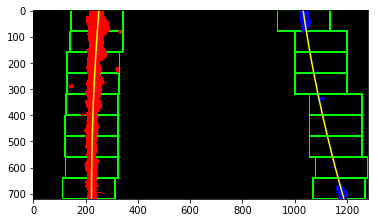

In [80]:
left_fit,right_fit,left_fitx,right_fitx, out_img = find_lane_pixels(pt_1)

plt.imshow(out_img)
plt.savefig('output_images/Sliding Window Search Detected lanes')

In [81]:
def search_around_poly(binary_warped,left_fit= None,right_fit=None):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    if (left_fit == None) & (right_fit == None):
        left_fit,right_fit,left_fitx,right_fitx,out_img = find_lane_pixels(binary_warped)
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin))) 
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (leftx.size == 0 or rightx.size == 0):
        return find_lane_pixels(binary_warped)

    # Fit new polynomials
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fit,right_fit,left_fitx,right_fitx,result

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # This is added back by InteractiveShellApp.init_path()


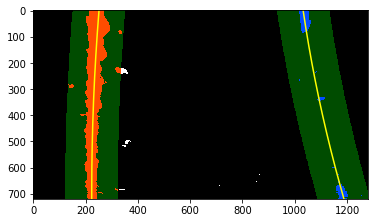

In [82]:
left_fit,right_fit,left_fitx,right_fitx,out_img = search_around_poly(pt_1,left_fit,right_fit)

plt.imshow(out_img)
plt.savefig('output_images/search from prior result')

In [83]:
def measure_curvature_pixels(binary_warped,left_fitx,right_fitx):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Make sure to feed in your real data instead in your project!
    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
   
    xm_per_pix=3.7/800
    ym_per_pix = 30/720
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implementation of the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [84]:
left_curverad, right_curverad = measure_curvature_pixels(pt_1,left_fitx,right_fitx)

print('Left line curvature:', left_curverad, 'm')
print('Right line curvature:', right_curverad, 'm')

Left line curvature: 3247.94574596 m
Right line curvature: 1936.55582671 m


In [85]:
def car_offset(binary_warped,left_fitx,right_fitx, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = binary_warped.shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (left_fitx[-1] + right_fitx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [86]:
offsetx = car_offset(pt_1,left_fitx,right_fitx)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.304042154168 m.


In [87]:
def fill_lane(img, binary_warped, left_fitx, right_fitx, Minv):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

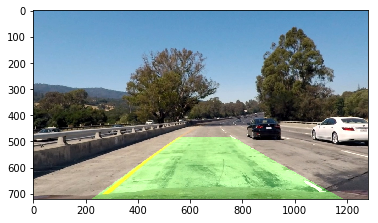

In [88]:
img_lanefill = fill_lane(undistorted, pt_1, left_fitx, right_fitx, Minv)

# Plot the results
plt.imshow(img_lanefill)
plt.savefig('output_images/Lane Fill')

In [89]:
def add_metrics(img,left_fitx,right_fitx,xm_per_pix=3.7/800, ym_per_pix = 30/720):    
    # Calculate radius of curvature
    left_curverad, right_curverad = measure_curvature_pixels(img,left_fitx, right_fitx)
    # Calculate car offset
    offsetx = car_offset(img,left_fitx,right_fitx)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(left_curverad), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(right_curverad), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

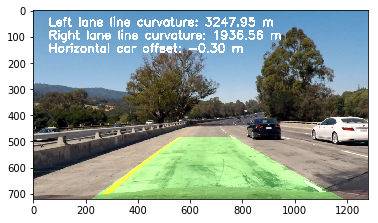

In [90]:
# Run the function
out_img = add_metrics(img_lanefill,left_fitx,right_fitx)

# Plot the results
plt.imshow(out_img)
plt.savefig('output_images/filled lane with metrics added')

In [93]:
class ProcessImage:
    def __init__(self,images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.left_fit = None
        self.right_fit = None

    def __call__(self, img):
        # Undistord image
        img = cal_undistort(img)

        # Combine all the thresholds to identify the lane lines
        binary =pipeline(img,r_thresh=(220,255), s_thresh=(180, 255), sx_thresh=(120, 255),l_thresh = (10,50))

        # Apply a perspective transform to rectify binary image ("birds-eye view")   

        warped, M, Minv = perpective_transform(binary)
        if (self.left_fit==None) or (self.right_fit ==None):
            self.left_fit,self.right_fit,left_fitx,right_fitx, out_img = find_lane_pixels(warped)
        else:
            self.left_fit,self.right_fit,left_fitx,right_fitx,result = search_around_poly(warped,left_fit,right_fit)
            

        # Warp the detected lane boundaries back onto the original image.
        img_lane = fill_lane(img, warped, left_fitx, right_fitx, Minv)
            
        # Add metrics to the output img
        out_img = add_metrics(img_lane,left_fitx, right_fitx)
            
        return out_img

[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


100%|█████████▉| 1260/1261 [07:04<00:00,  2.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 4min 31s, sys: 25.3 s, total: 4min 56s
Wall time: 7min 7s


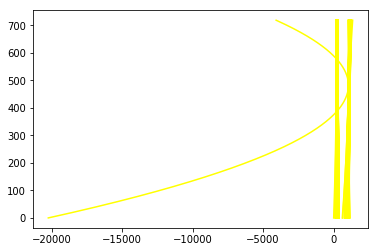

In [94]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)